Use this utlity to update the correlations between asset classes in universe/asset-prices.csv

input files:
- asset-classes-2-etf.csv: mapping of asset classes to a representative ETF to use for calculating correlations
- asset-classes-in.csv: asset pairs for which to calculate correlations

output files:
- symbols-cache/'symbol'.csv: timeseries for each symbol 
- symbols-timeseries.csv: compiled timeseries for symbols
- universe/asset-classes.csv: asset class pairs with correlations

In [47]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [48]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import brownbear as bb

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [49]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Globals

In [50]:
# set refresh_timeseries=True to download timeseries.  Otherwise /symbol-cache is used.
refresh_timeseries = True

In [51]:
# asset2etf dict provides a mapping from the asset name to a representative etf
asset2etf = pd.read_csv('asset-classes-2-etf.csv', skip_blank_lines=True, comment='#')
asset2etf = asset2etf.set_index(['Asset Class'])
asset2etf = asset2etf['ETF'].to_dict()
asset2etf

{'US Stocks': 'VTSMX',
 'Global Stocks': 'VXUS',
 'US Bonds': 'AGG',
 'Global Bonds': 'BNDX',
 'Cash Equivalents': 'BIL',
 'Real Estate': 'VNQ',
 'Commodities': 'DBC',
 'Currencies': 'DBV',
 'Managed Futures': 'FUT',
 'Balanced': 'AOM',
 'Risk-Free Asset': 'BIL',
 'US Stocks:Large Cap': 'SPY',
 'US Stocks:Mid Cap': 'MDY',
 'US Stocks:Small Cap': 'IWM',
 'US Stocks:Growth': 'QQQ',
 'US Stocks:Growth and Income': 'VOO',
 'US Stocks:Value': 'IWD',
 'US Stocks:Total Stock Market': 'VTI',
 'US Stocks:Materials': 'XLB',
 'US Stocks:Communication Services': 'XLC',
 'US Stocks:Energy': 'XLE',
 'US Stocks:Financials': 'XLF',
 'US Stocks:Industrials': 'XLI',
 'US Stocks:Technology': 'XLK',
 'US Stocks:Consumer Staples': 'XLP',
 'US Stocks:Real Estate': 'XLRE',
 'US Stocks:Utilities': 'XLU',
 'US Stocks:Healthcare': 'XLV',
 'US Stocks:Consumer Discretionary': 'XLY',
 'Global Stocks:Asia': 'VPL',
 'Global Stocks:Developed Markets': 'EFA',
 'Global Stocks:Emerging Markets': 'EEM',
 'Global Stocks:E

In [52]:
symbols = set(asset2etf.values())

In [53]:
bb.fetch_timeseries(symbols, refresh=refresh_timeseries)
bb.compile_timeseries(symbols)

.....................................................................


In [54]:
df = pd.read_csv('symbols-timeseries.csv', skip_blank_lines=True, comment='#')
df.set_index("Date", inplace=True)
df['VTSMX']

Date
2015-01-02    46.33
2015-01-05    45.51
2015-01-06    45.07
2015-01-07    45.61
2015-01-08    46.41
              ...  
2021-02-22    99.22
2021-02-23    99.22
2021-02-24   100.37
2021-02-25   100.37
2021-02-26    97.40
Name: VTSMX, Length: 1549, dtype: float64

0.9252944649216028

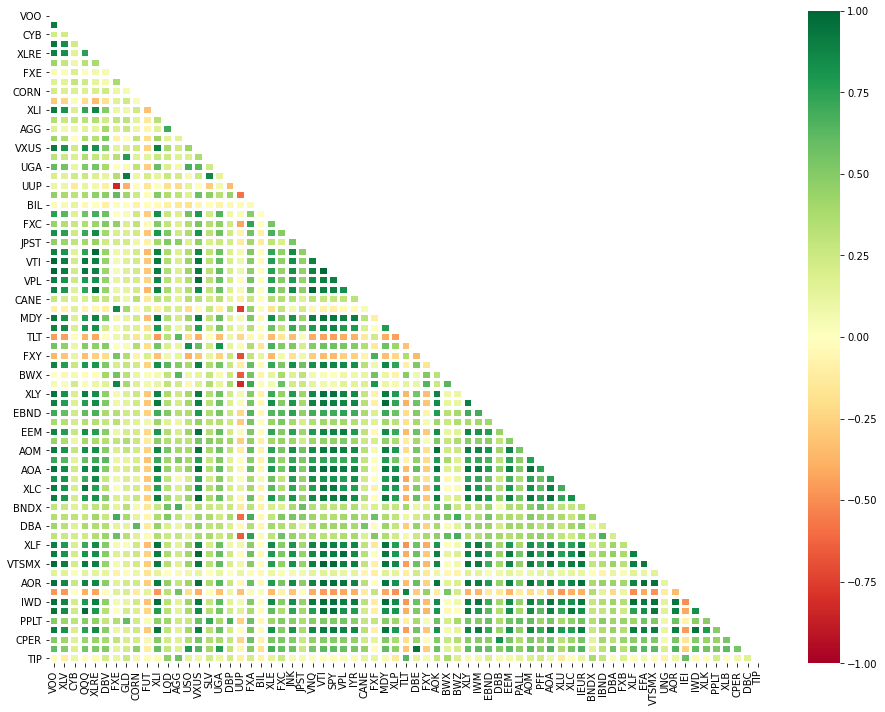

In [55]:
corr_map = bb.correlation_map(df, method='log', days=bb.TRADING_DAYS_PER_YEAR)
corr_map['SPY']['VXUS']

In [56]:
# read asset-classes-in.csv
lines = []
with open('asset-classes-in.csv', 'r') as f:
    lines = [line.strip() for line in f]
#lines

In [57]:
# calculate the pair correlations between the assets and write
# the resuls to a list
out = []
for line in lines:
    # copy empty and comment lines
    if not line or line.startswith('#'):
        out.append(line)
        continue
    # split line by comma delimiter; strip the fields
    fields = line.split(',')
    fields = [field.strip() for field in fields]
    assetA = fields[0].strip('\"')
    assetB = fields[1].strip('\"')
    # copy same asset lines and header
    if assetA == assetB or assetA == 'Asset Class A':
        out.append(line)
        continue
    # use asset2etf to get a representative etf for the asset,
    # then calculate the correlation.  The etf pair correlation is
    # a proxy for the correlation of an asset pair
    etfA = asset2etf[assetA]
    etfB = asset2etf[assetB]
    corrAB = corr_map.loc[etfA, etfB]
    out.append('"{}","{}","{:0.2f}"'.format(assetA, assetB,corrAB))   

In [58]:
# write out asset-classes.csv
with open('asset-classes.csv', 'w') as f:
    for line in out:
        f.write(line + '\n')

In [59]:
# sample symbol
symbol = 'SPY'

In [60]:
annual_returns = bb.annualize_returns(df, timeperiod='daily', years=1)
annual_returns[symbol]

30.23531965063231

In [61]:
# calculate annualized returns
annual_returns_1mo = bb.annualize_returns(df, timeperiod='daily', years=1/12)
annual_returns_3mo = bb.annualize_returns(df, timeperiod='daily', years=3/12)
annual_returns_1yr = bb.annualize_returns(df, timeperiod='daily', years=1)
annual_returns_3yr = bb.annualize_returns(df, timeperiod='daily', years=3)
annual_returns_5yr = bb.annualize_returns(df, timeperiod='daily', years=5)

In [62]:
# calculate volatility
daily_returns = df.pct_change()
years = bb.TRADING_DAYS_PER_MONTH / bb.TRADING_DAYS_PER_YEAR
vola = bb.annualized_standard_deviation(daily_returns, timeperiod='daily', years=years)
vola[symbol]

0.1551651597358937

In [63]:
# calculate downside volatility
ds_vola = bb.annualized_standard_deviation(daily_returns, timeperiod='daily', years=years, downside=True)
ds_vola[symbol]

0.10522763814476854

In [64]:
# resample df on a monthly basis
df.index = pd.to_datetime(df.index)
monthly = df.resample('M').ffill()
bb.print_full(monthly[symbol])

Date
2015-01-31   177.43
2015-02-28   187.40
2015-03-31   184.46
2015-04-30   186.27
2015-05-31   188.66
2015-06-30   184.83
2015-07-31   189.01
2015-08-31   177.49
2015-09-30   172.96
2015-10-31   187.67
2015-11-30   188.36
2015-12-31   185.10
2016-01-31   175.89
2016-02-29   175.74
2016-03-31   187.56
2016-04-30   188.30
2016-05-31   191.50
2016-06-30   192.17
2016-07-31   199.18
2016-08-31   199.42
2016-09-30   199.43
2016-10-31   195.97
2016-11-30   203.19
2016-12-31   207.31
2017-01-31   211.02
2017-02-28   219.31
2017-03-31   219.58
2017-04-30   221.76
2017-05-31   224.89
2017-06-30   226.33
2017-07-31   230.98
2017-08-31   231.65
2017-09-30   236.32
2017-10-31   241.89
2017-11-30   249.28
2017-12-31   252.31
2018-01-31   266.53
2018-02-28   256.84
2018-03-31   249.80
2018-04-30   251.09
2018-05-31   257.19
2018-06-30   258.67
2018-07-31   268.25
2018-08-31   276.81
2018-09-30   278.46
2018-10-31   259.22
2018-11-30   264.03
2018-12-31   240.78
2019-01-31   260.06
2019-02-28   26

In [65]:
# calculate monthly returns
monthly_returns = monthly.pct_change()
monthly_returns['SPY']

Date
2015-01-31     nan
2015-02-28    0.06
2015-03-31   -0.02
2015-04-30    0.01
2015-05-31    0.01
              ... 
2020-10-31   -0.02
2020-11-30    0.11
2020-12-31    0.04
2021-01-31   -0.01
2021-02-28    0.03
Freq: M, Name: SPY, Length: 74, dtype: float64

In [66]:
# calculate standard deviation
std_dev = bb.annualized_standard_deviation(monthly_returns, timeperiod='monthly', years=3)
std_dev[symbol]

0.18086040666724604

In [67]:
# read investment-options-header.csv
lines = []
with open('investment-options-in.csv', 'r') as f:
    lines = [line.strip() for line in f]
lines

['# Description: S&P 500 investment options. 09/29/2020',
 '',
 '# Format',
 '"Investment Option","Asset Class","1 mo","3 mo","1 Yr","3 Yr","5 Yr","Vola","DS Vola","Std Dev"',
 '# Note: "Description" field is optional']

In [68]:
# for each symbol, write out the 1 Yr, 3 Yr, 5 Yr, and std dev
out = lines.copy()

# This is still slow (2.53 s)
for key, value in asset2etf.items():

    symbol = value
    asset_class = key

    ret_1mo = annual_returns_1mo[symbol]
    ret_3mo = annual_returns_3mo[symbol]
    ret_1yr = annual_returns_1yr[symbol]
    ret_3yr = annual_returns_3yr[symbol]
    ret_5yr = annual_returns_5yr[symbol]

    if np.isnan(ret_3yr): ret_3yr = ret_1yr
    if np.isnan(ret_5yr): ret_5yr = ret_3yr
    
    _vola = vola[symbol]*100
    _ds_vola = ds_vola[symbol]*100
    sd = std_dev[symbol]*100

    out.append(
        '"{}","{}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}"'
        .format(asset_class, asset_class,
                ret_1mo, ret_3mo, ret_1yr, ret_3yr, ret_5yr, _vola, _ds_vola, sd)) 

In [69]:
# write out asset-classes.csv
with open('investment-options.csv', 'w') as f:
    for line in out:
        f.write(line + '\n')